# 6.6: Canada Wildfires Sourcing & Analyzing Time Series Data
** **

## This script contains the following:


1. Importing libraries and files


2. Data cleaning (Subsetting, wrangling, and cleaning time-series data)


3. Time series analysis: decomposition


4. Testing for stationarity via ADF (Augmented Dickey Fuller) test


5. Stationarizing the Canadian WildFires data
    - 5.1 Normal Differencing method
    
   
6. Time series forecasting with ARIMA model (Bonus)

      - 6.1 Splitting the data 
      - 6.2 Running and fitting the model
      - 6.3 Iterating
      - 6.4 Seasonal-ARIMA

** **

### 1. Importing libraries and files
** **


In [1]:
import quandl
import pandas as pd
import numpy as np
from numpy import inf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# This command propts matplotlib visuals to appear in the notebook 

%matplotlib inline

### Connecting to Quandl 
** **

In [3]:
# Configure API key 

quandl.ApiConfig.api_key = 'p4cEFimyNx-YYyqSyztv'

In [4]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

quandl_data = quandl.get('FRED/NROU')

In [5]:
quandl_data.head()

,Value
Date,
1949-01-01,5.255053
1949-04-01,5.261516
1949-07-01,5.268013
1949-10-01,5.274564
1950-01-01,5.281182


### - I decided to continue with my data on Canadian wildfires to analyze the time series

In [6]:
# Creating a shared path

path = r'C:\Users\mehrn\OneDrive\Desktop\CareerFoundry Materials\Tasks\06 Advanced Analytics\15-03-2023 Canada Wildfires Analysis'

In [7]:
# Importing the fires data

df_fires = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'updated_wildfires.pkl'))

In [8]:
df_fires.head()

,src_agency,latitude,longitude,rep_date,size,cause,prot_zone,eco_name,size_class,total_fires
fire_id,,,,,,,,,,
0,BC,59.963,-128.172,1953-05-26,8.0,H,,Boreal Cordillera,Class C,149391
1,BC,59.318,-132.172,1950-06-22,8.0,L,,Boreal Cordillera,Class C,149391
2,BC,59.876,-131.922,1950-06-04,12949.9,H,,Boreal Cordillera,Class E,149391
3,BC,59.760,-132.808,1951-07-15,241.1,H,,Boreal Cordillera,Class E,149391
4,BC,59.434,-126.172,1952-06-12,1.2,H,,Boreal Cordillera,Class B,149391


### 2. Data cleaning (Subsetting, wrangling, and cleaning time-series data)
** **

In [9]:
# Checking columns and their data types

df_fires.dtypes

src_agency      object
latitude       float64
longitude      float64
rep_date        object
size           float64
cause           object
prot_zone       object
eco_name        object
size_class      object
total_fires      int64
dtype: object

In [10]:
# Convert the rep_date to datetime64 data type
from datetime import datetime

# Create a datetime column from 'rep_date' with format of year-month-day
df_fires['rep_date'] = pd.to_datetime(df_fires['rep_date'], format='%Y-%m-%d')

In [11]:
df_fires.dtypes

src_agency             object
latitude              float64
longitude             float64
rep_date       datetime64[ns]
size                  float64
cause                  object
prot_zone              object
eco_name               object
size_class             object
total_fires             int64
dtype: object

In [12]:
# Filter data between two dates (last 5 years)

df_filtered = df_fires.loc[(df_fires['rep_date'] >= '2017-01-01') & (df_fires['rep_date'] < '2022-01-01')]

# Display
df_filtered

,src_agency,latitude,longitude,rep_date,size,cause,prot_zone,eco_name,size_class,total_fires
fire_id,,,,,,,,,,
134869,BC,59.93270,-128.498000,2017-08-13,0.0090,L,,Boreal Cordillera,Class A,149391
134871,BC,59.72100,-126.409500,2017-07-15,1.3000,L,,Boreal Cordillera,Class B,149391
134925,BC,59.45350,-121.001200,2017-08-30,301.1000,L,,Taiga Plain,Class E,149391
134926,BC,59.02470,-120.947100,2017-08-30,173.2000,L,,Taiga Plain,Class E,149391
134927,BC,59.77330,-123.860500,2017-09-09,0.8000,L,,Taiga Plain,Class B,149391
...,...,...,...,...,...,...,...,...,...,...
423826,PC-WB,59.61015,-113.985117,2021-07-08,65.1000,L,Monitored Response,Taiga Plain,Class D,1910
423827,PC-WL,49.11120,-113.836000,2021-03-04,7.6000,H-PB,Prescribed Fire,Montane Cordillera,Class C,61
423828,PC-WL,49.11220,-113.840500,2021-03-17,2.9000,H-PB,Prescribed Fire,Montane Cordillera,Class B,61


In [13]:
# Grouping by date and cause to count the human-caused(H) fires in the past 5 years

df_sub = df_filtered.groupby('rep_date')['cause'].apply(lambda x: (x=='H').sum()).reset_index(name='human_caused_count')
df_sub

,rep_date,human_caused_count
0,2017-01-01,1
1,2017-01-09,1
2,2017-01-18,1
3,2017-01-19,1
4,2017-01-23,1
...,...,...
1268,2021-12-09,1
1269,2021-12-10,1
1270,2021-12-11,1
1271,2021-12-13,0


In [14]:
# Checking for missing values

df_sub.isnull().sum()

rep_date              0
human_caused_count    0
dtype: int64

In [15]:
# Checking for duplicates

dup = df_sub[df_sub.duplicated()]
dup

,rep_date,human_caused_count


In [16]:
# Set the datetime (rep_date) variable as the index of the dataframe.

df_sub = df_sub.set_index('rep_date')
df_sub

,human_caused_count
rep_date,
2017-01-01,1
2017-01-09,1
2017-01-18,1
2017-01-19,1
2017-01-23,1
...,...
2021-12-09,1
2021-12-10,1
2021-12-11,1


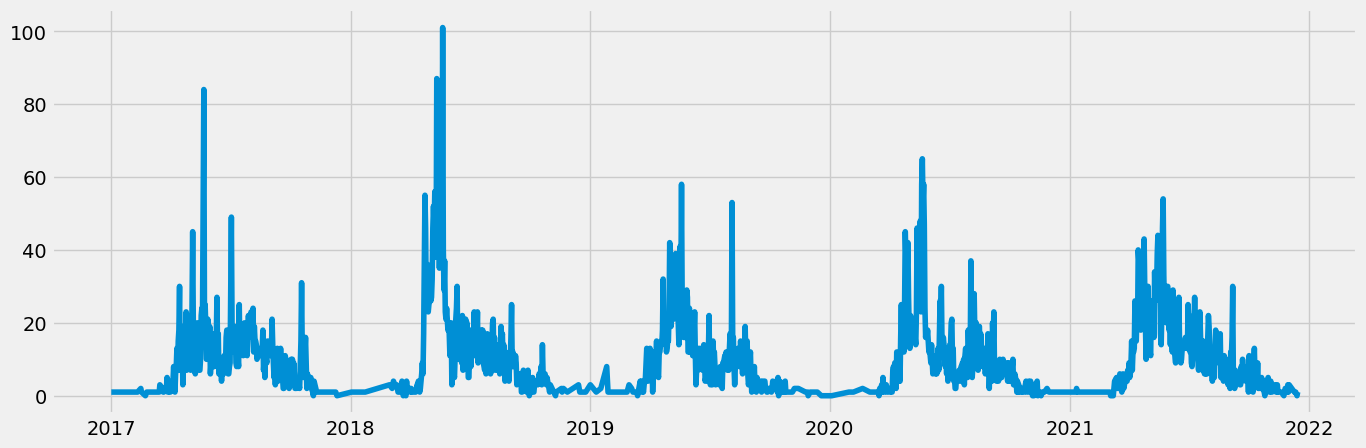

In [17]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(df_sub)

### 3. Time-series analysis: decomposition
** **

In [18]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_sub, model='additive',  period=365)

In [19]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

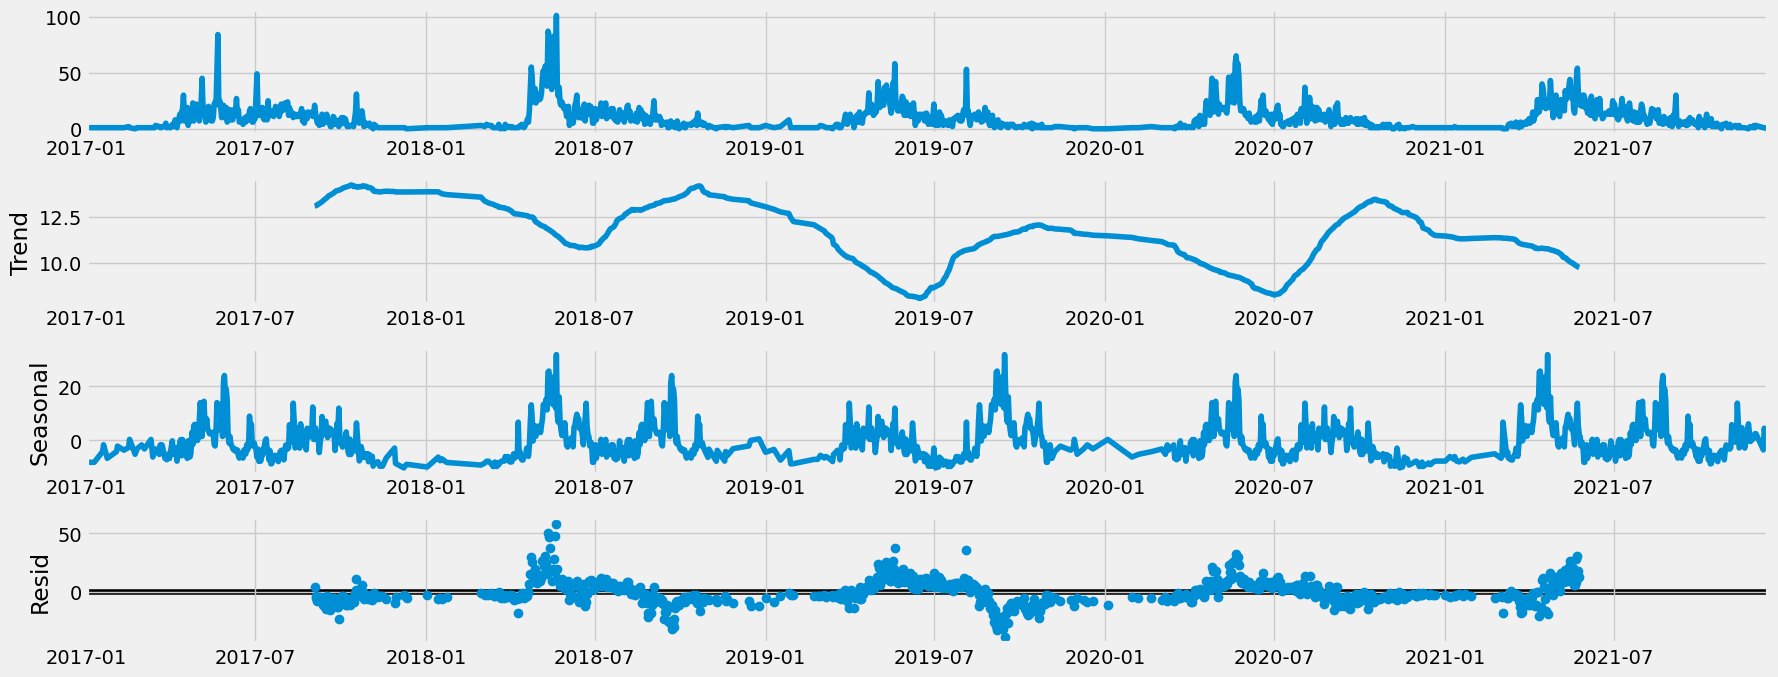

In [20]:
# Plot the separate components

decomposition.plot()
plt.show()

### Observation:
Looking at decomposition plots (which represent the different components of our time series), the Seasonal component seems to be more prominent (the shape of the plot is so close to the original series). This might be because of the fire season in Canada which is usually July to September. We can see seasonality in the time series where its value ranges from ~-5 to ~+13. Also, the Residual chart values is showing an obvious pattern similar to the original data. As we used an additive model, any data point with a value of 0 (in each component) doesn't have a contribution to the fires' time series.

### 4. Testing for stationarity via ADF (Augmented Dickey Fuller) test
** **

- H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.

- HA: The time series is stationary.

- If the p-value from the test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that the time series is stationary.


In [21]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_sub['human_caused_count'])

Dickey-Fuller Stationarity test:
Test Statistic                   -4.965217
p-value                           0.000026
Number of Lags Used               9.000000
Number of Observations Used    1263.000000
Critical Value (1%)              -3.435538
Critical Value (5%)              -2.863831
Critical Value (10%)             -2.567990
dtype: float64


### Results:

We reject the null hypothesis since the P-Value is less than 0.05 (p-value = 0.000026). So this time series is Stationary. If it was not, to build or train an ML model, we would need to make our time series stationary. To do that we could use three different methods: Differencing (normal, seasonal), Rolling stats (moving average), and differencing + Transformation (log, square root, cube root).

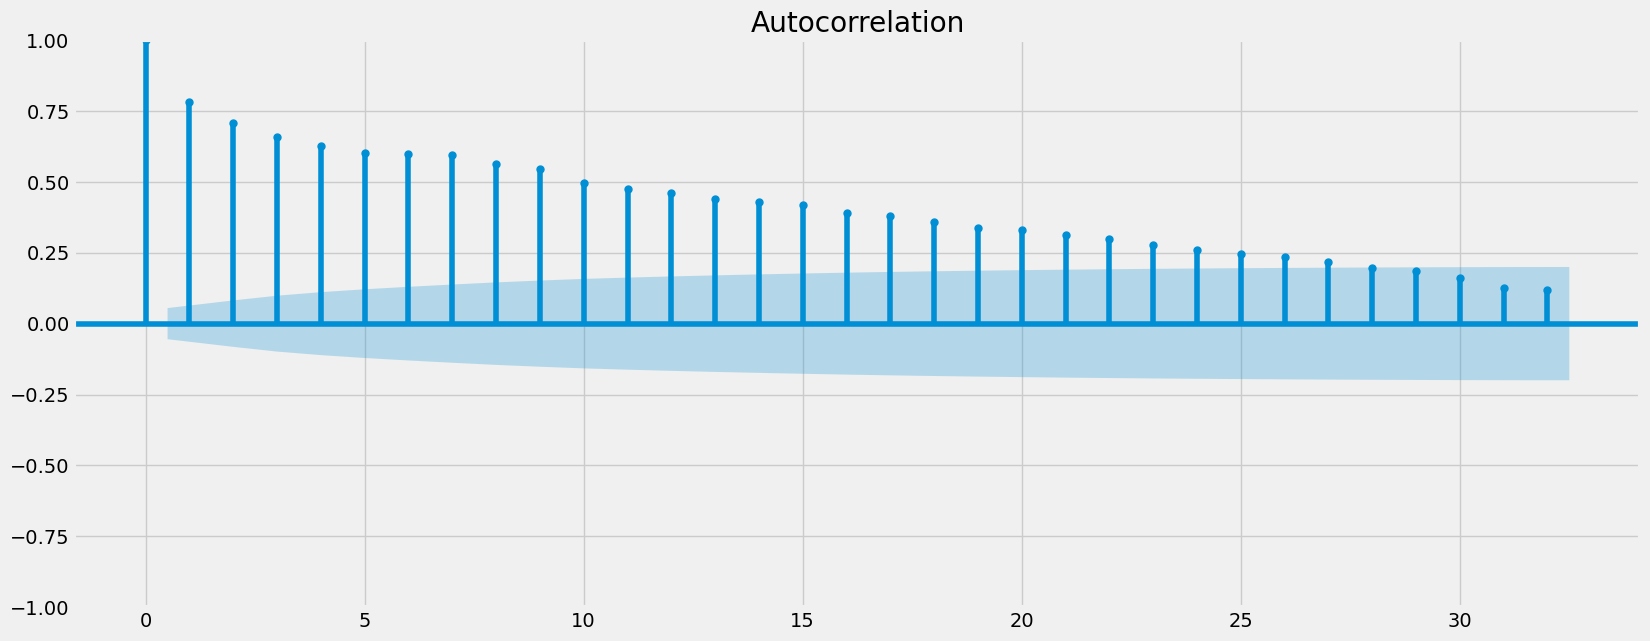

In [22]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_sub)

plt.show()

### Observation: 
There are a number of lines above the blue confidence interval. This means that, despite the Dickey-Fuller test saying that our data is stationary, that stationarity is weak. 
We will conduct a round of differencing to stationarize it further and reduce the remaining autocorrelated terms.

### 5. Stationarizing the Canadian WildFires data
** **

#### 5.1 Differencing method
** **

In [23]:
data_diff = df_sub - df_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [24]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

data_diff.tail()

,human_caused_count
rep_date,
2021-12-09,-2.0
2021-12-10,0.0
2021-12-11,0.0
2021-12-13,-1.0
2021-12-14,1.0


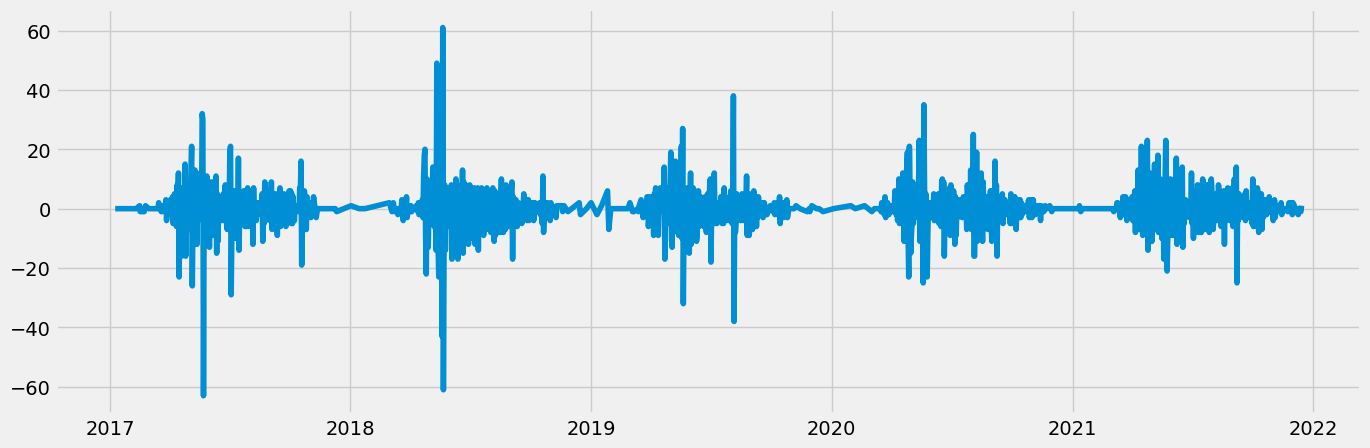

In [25]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [26]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.480235e+01
p-value                        2.090168e-27
Number of Lags Used            8.000000e+00
Number of Observations Used    1.263000e+03
Critical Value (1%)           -3.435538e+00
Critical Value (5%)           -2.863831e+00
Critical Value (10%)          -2.567990e+00
dtype: float64


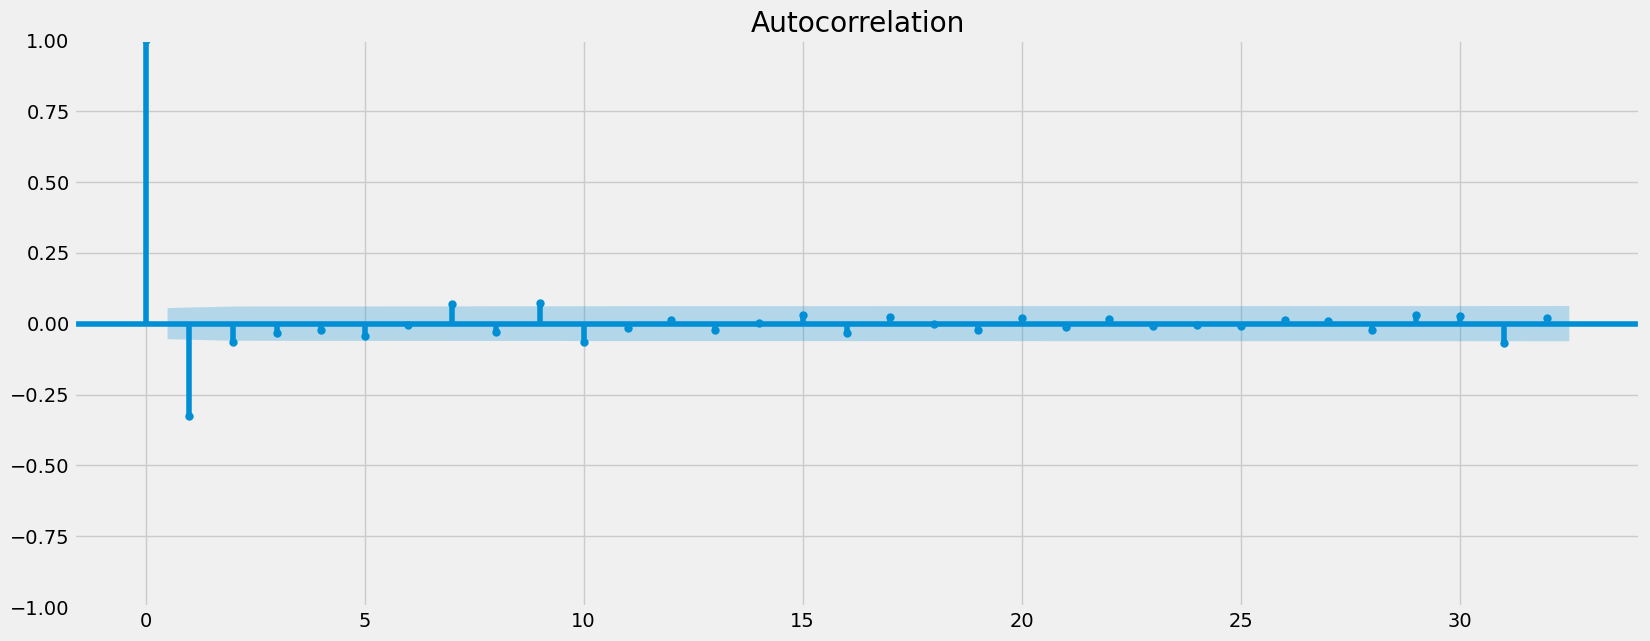

In [27]:
plot_acf(data_diff)
plt.show()

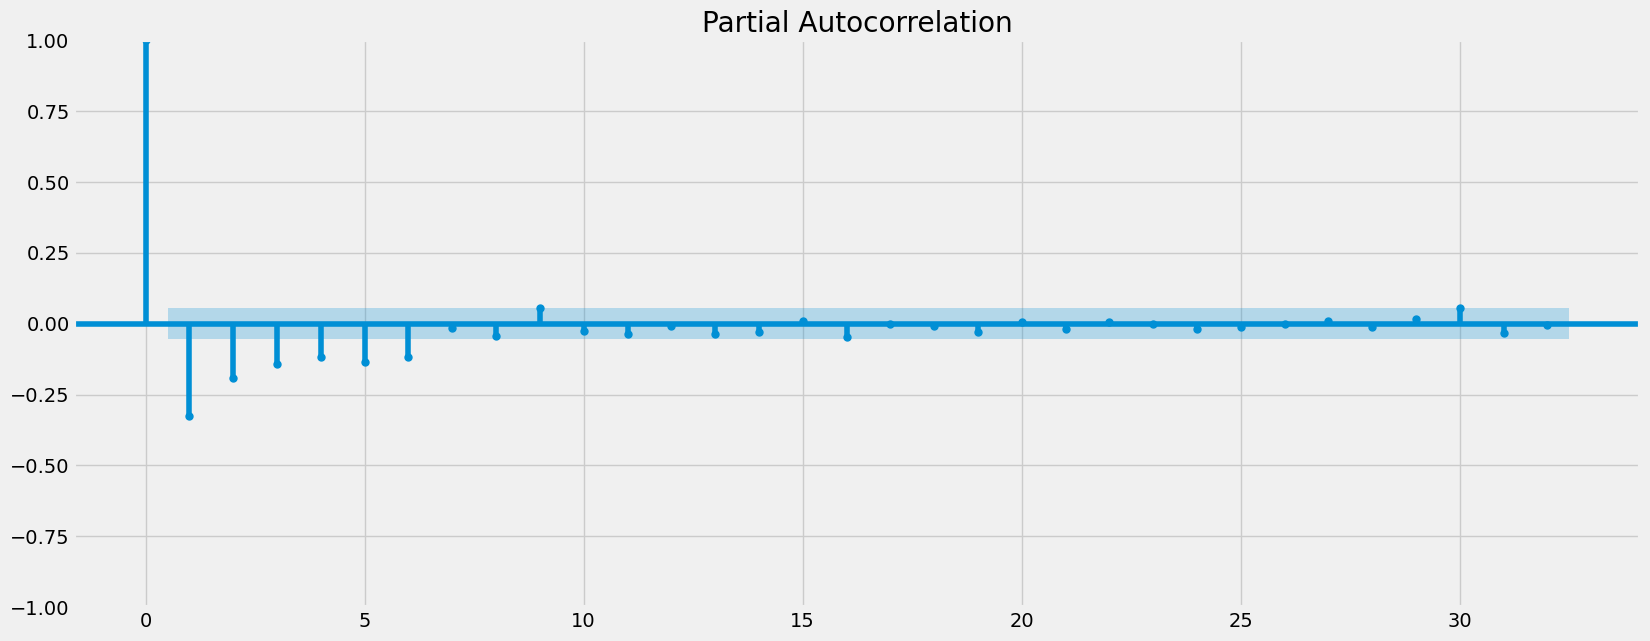

In [28]:
plot_pacf(data_diff)
plt.show()

### Observation: 
While the autocorrelation plot has improved, there are still a number of lines above the blue confidence interval. 

We will also use the Autocorrelation and Partial Autocorrelation plots for a quick way to find the **P** and **q** in **ARIMA** model. We will start with **p= 5** and **q=7**. As we did one round of differencing the value of **d** would be **1**.

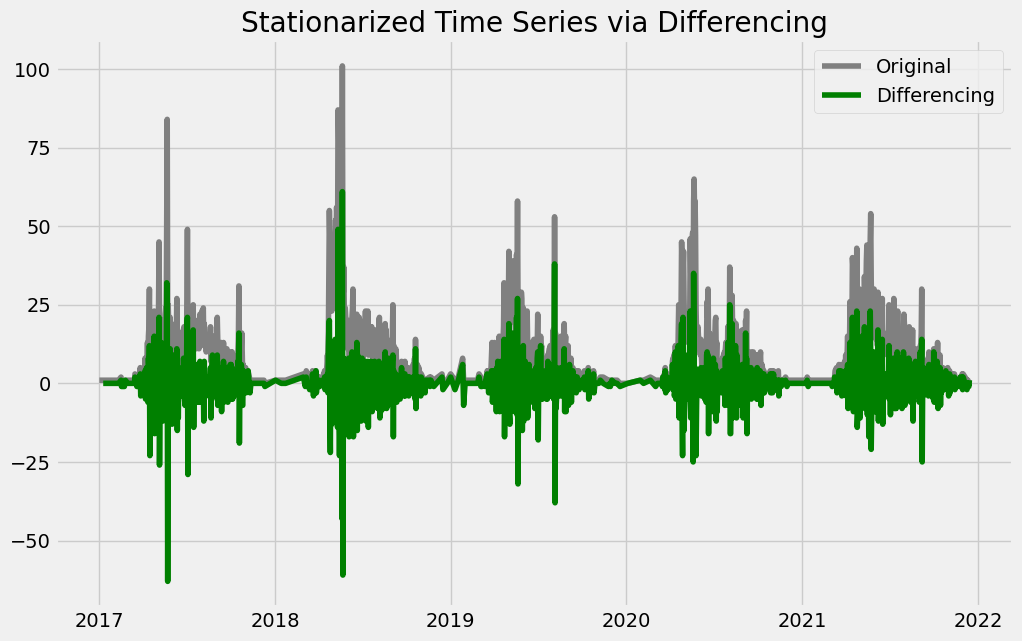

In [29]:
# Presenting how stationarizied plot fits on Original time series

fig = plt.figure(figsize=(11,7))
orig = plt.plot(df_sub, color = 'gray', label= 'Original')
mean = plt.plot(data_diff, color = 'green', label = 'Differencing')
plt.legend(loc = 'best')
plt.title('Stationarized Time Series via Differencing')
plt.show(block = False)

### 6. Time series forecasting with ARIMA model (Bonus)
** **

#### 6.1 Splitting the data 
** **

In [30]:
data_diff.shape

(1272, 1)

In [31]:
# Split the data

train = data_diff[data_diff.index < '2021-06-01']
test = data_diff[data_diff.index >= '2021-06-01']

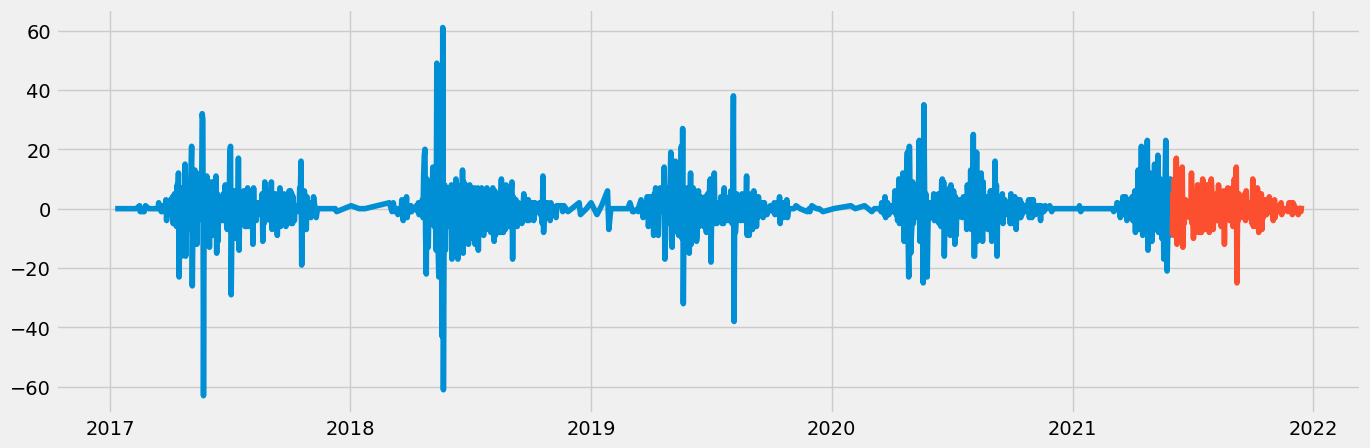

In [32]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [33]:
test.shape

(176, 1)

#### 6.2 Running and fitting the model
** **

In [34]:
from statsmodels.tsa.api import ARIMA# , SARIMAX # Import the model you need

                               SARIMAX Results                                
Dep. Variable:     human_caused_count   No. Observations:                 1096
Model:                 ARIMA(5, 1, 7)   Log Likelihood               -3682.887
Date:                Sat, 01 Apr 2023   AIC                           7391.775
Time:                        11:02:46   BIC                           7456.755
Sample:                             0   HQIC                          7416.363
                               - 1096                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1758      0.102    -11.580      0.000      -1.375      -0.977
ar.L2         -0.2368      0.180     -1.316      0.188      -0.590       0.116
ar.L3         -0.0403      0.157     -0.257      0.7

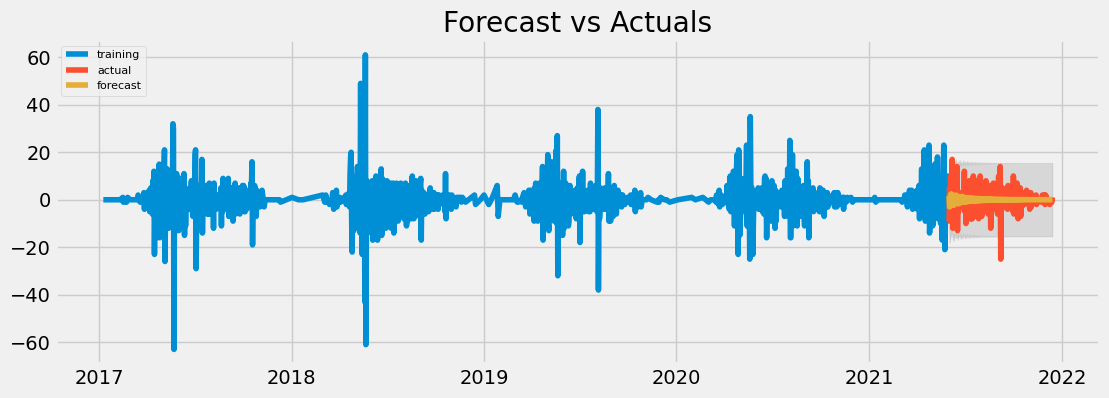

In [35]:
model = ARIMA(train, order=(5, 1, 7))  # ARIMA ORDER = (p,d,q)
fitted = model.fit()  
print(fitted.summary()) # Check model summary

# Forecast
fc = fitted.get_forecast(176, alpha=0.05)  # 95% confidence interval  --> alpha = 0.05; 176 is the shape of the test set

# Make into pandas series
fc_series = pd.Series(fc.predicted_mean, index=test.index)# This creates the forecasted curve


fc_series = fc.predicted_mean
lower_series = fc.conf_int().iloc[:, 0] # lower bound of the confidence interval
upper_series = fc.conf_int().iloc[:, 1] # Upper bound of the confidence interval

fc_series.index = test.index
lower_series.index = test.index
upper_series.index = test.index

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.1) # This creates the confidence interval
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### 6.3 Iterating
** **

                               SARIMAX Results                                
Dep. Variable:     human_caused_count   No. Observations:                 1096
Model:                 ARIMA(6, 1, 2)   Log Likelihood               -3691.133
Date:                Sat, 01 Apr 2023   AIC                           7400.266
Time:                        11:02:48   BIC                           7445.253
Sample:                             0   HQIC                          7417.289
                               - 1096                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9254      0.145     -6.364      0.000      -1.210      -0.640
ar.L2         -0.5235      0.069     -7.586      0.000      -0.659      -0.388
ar.L3         -0.3857      0.049     -7.837      0.0

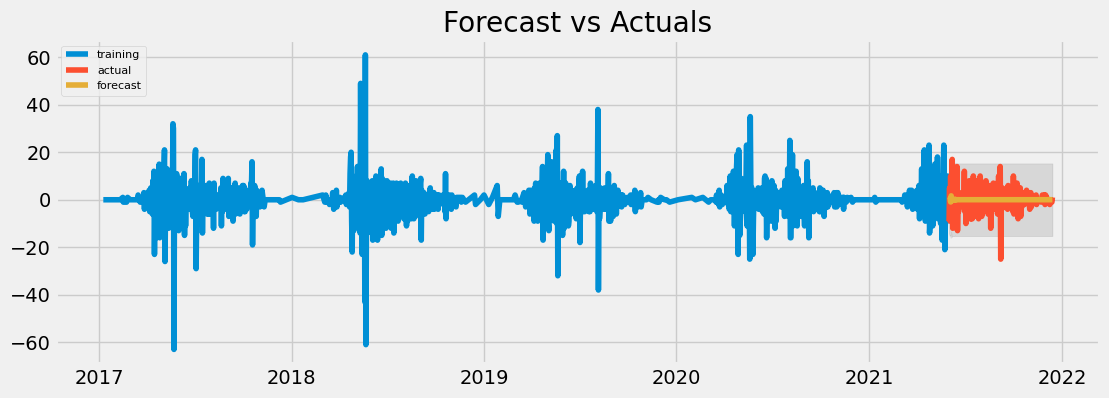

In [36]:
model = ARIMA(train, order=(6, 1, 2))  # ARIMA ORDER = (p,d,q)
fitted = model.fit()  
print(fitted.summary()) # Check model summary

# Forecast
fc = fitted.get_forecast(176, alpha=0.05)  # 95% confidence interval  --> alpha = 0.05; 176 is the shape of the test set

# Make into pandas series
fc_series = fc.predicted_mean # This creates the forecasted curve
lower_series = fc.conf_int().iloc[:, 0] # lower bound of the confidence interval
upper_series = fc.conf_int().iloc[:, 1] # Upper bound of the confidence interval

fc_series.index = test.index
lower_series.index = test.index
upper_series.index = test.index


# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.1) # This creates the confidence interval
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### 6.4 Seasonal-ARIMA
** **

                                     SARIMAX Results                                      
Dep. Variable:                 human_caused_count   No. Observations:                 1096
Model:             SARIMAX(6, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3682.042
Date:                            Sat, 01 Apr 2023   AIC                           7382.083
Time:                                    11:02:55   BIC                           7426.970
Sample:                                         0   HQIC                          7399.077
                                           - 1096                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4580      0.013    -34.773      0.000      -0.484      -0.432
ar.L2         -0.3192      0.019   

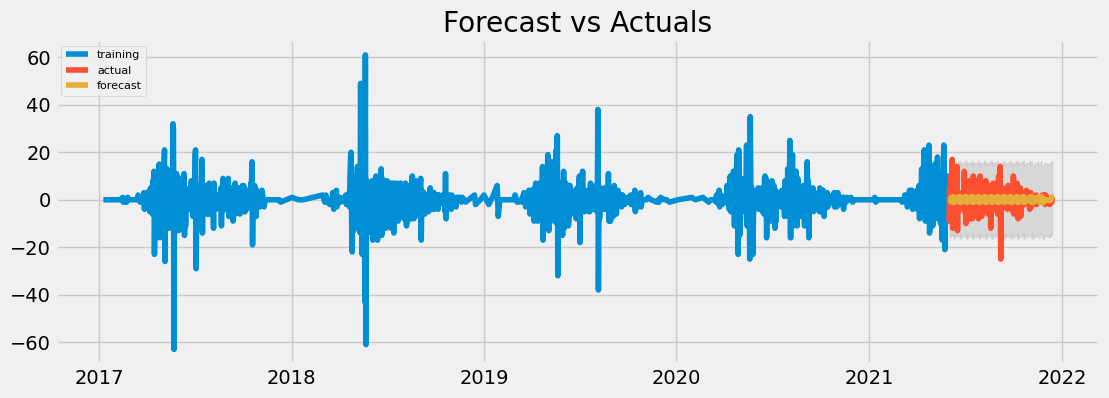

In [37]:
model_s = sm.tsa.SARIMAX(train, order=(6,1,1), seasonal_order=(0,1,1,12))
fitted = model_s.fit()  
print(fitted.summary()) # Check model summary

# Forecast
fc = fitted.get_forecast(176, alpha=0.05)  # 95% confidence interval  --> alpha = 0.05; 176 is the shape of the test set

# Make into pandas series
fc_series = fc.predicted_mean # This creates the forecasted curve
lower_series = fc.conf_int().iloc[:, 0] # lower bound of the confidence interval
upper_series = fc.conf_int().iloc[:, 1] # Upper bound of the confidence interval

fc_series.index = test.index
lower_series.index = test.index
upper_series.index = test.index


# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.1) # This creates the confidence interval
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()